# bert
## NLP里的迁移学习
* 使用预训练好的模型来抽取词、句子的特征
  * 例如word2vec或语言模型
* 不更新与训练好的模型
* 需要构建新的网络来抓起新任务需要的信息
  * word2vec忽略了时序信息，语言模型只看了一个方向

## bert的动机 
<img src='./image/NLP.jpg' alt='NLP' width=300><br>

* 基于微调的NLP模型
* 预训练的模型抽取了足够多的信息
* 新的任务只需要增加一个简单的输出

## bert架构
* 只有编码器的Tansformer
* 两个版本
  * Base: #blocks = 12, hidden size = 768, #heads = 12, 
      #parameters = 110M
  * Large: #blocks = 24, hidden size = 1024, #heads = 16, 
      #parameter = 340M 
* 在大规模数据上训练>

## bert创新
### 对输入的修改
* 每个样本是一个句子对, 原本的是原数据进入encoder，目标数据进入decoder但是bert只有encoder所以将两个句子拼接成一个句子对
* 加入额外的片段嵌入
* 位置编码可以学习

<img src='../img/bert-input.svg' alt='bert-input' width=400><br>
cls是指分类，sep指句子之间的分隔符<br>
segment embedding对于每个句子段加入不同的嵌入段<br>

### 预训练任务1: 带掩码的语言模型
希望训练通用模型，不仅对于某一场景（语言模型，给出前面的词徐策下一个词）<br>
* 但是Transformer的编码器是双向的，标准语言模型要求单向
* 代言吗的语言模型每次岁次(15%的概率)将一些词元替换为mask（完形填空，而不是预测未来）
* 因为微调任务中不出现mask(数据集中有mask但是finetune的数据集没有mask)
  * 80%概率下，将选中的词元变成mask
  * 10%概率下换成一个随机词元
  * 10%该类别下保持原有的词元

### 预训练任务2: 下一句子预测
* 预测一个句子对中两个句子是不是相邻
* 训练样本中
  * 50%概率选择相邻句子对`<cls> this movie is geat <sep> i like it <sep>`
  * 50%概率选择随机句子对`<cls> this movie is geat <sep> hello world <sep>`


## bert代码

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    segments = [0] * (len(tokens_a) + 2) # 分段向量
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

### encoder
bert只负责把所有的token编码化

In [4]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens) # 每个词有一个专属向量
        self.segment_embedding = nn.Embedding(2, num_hiddens) # 0,1做嵌入
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :] # 找到需要的长度
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 768, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

tokens = torch.randint(0, vocab_size, (2, 8)) # 范围加形状
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape, tokens.shape, tokens

(torch.Size([2, 8, 768]),
 torch.Size([2, 8]),
 tensor([[8951, 9247, 7860, 1232, 1190, 1238, 5658, 1935],
         [9381, 5189, 6679, 2701, 9126, 8663, 2723, 9028]]))

### masked language modeling

1. 输入文本 → 分词 → 转为 token 索引
2. 随机mask部分token，记录mask位置
3. 输入 token 索引和 segment 信息到 BERT 编码器，得到每个token的特征
4. 将编码器输出和mask位置输入 MaskLM，预测被mask位置的词
5. 与真实被mask词做损失计算，反向传播训练

In [6]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions): # 被mask掉的位置
        # X: (batch_size, seq_len, num_inputs)
        num_pred_positions = pred_positions.shape[1] # 输入是二维的batch*masklen
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions] # masked_X[i] = X[batch_idx[i], pred_positions[i]]等价于
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1)) # 变回原来的形状
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [7]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]]) # 每个batch的mask位置
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [8]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

### next sentence prediction
预测下一个句子是否是上一个句子的下一句，是一个二分类任务

In [9]:
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)

    def forward(self, X):
        return self.output(X)

In [ ]:
encoded_X = torch.flatten(encoded_X, start_dim=1) # shape原本为batch, seqlen, numhidden
nsp = NextSentencePred(encoded_X.shape[-1]) # 因为只用0位置，所以seqlen=1
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape, encoded_X.shape

(torch.Size([2, 2]), torch.Size([2, 6144]))

In [10]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

### 最终模型

In [11]:
class BERTModel(nn.Module):
    """The BERT model."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 hid_in_features=768, mlm_in_features=768,
                 nsp_in_features=768):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape,
                    ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
                    dropout, max_len=max_len, key_size=key_size,
                    query_size=query_size, value_size=value_size)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features)
        self.nsp = NextSentencePred(nsp_in_features)

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :])) # 只需要用<cls>位置的输出作为句子的分类
        return encoded_X, mlm_Y_hat, nsp_Y_hat

## dataset for pretraining bert


In [12]:
import os
import random
import torch
from d2l import torch as d2l

In [13]:
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

def _read_wiki(data_dir): # 分割成段落+句子
    # [
    #     ['sentence1', 'sentence2', ...],   # 第一段
    #     ['sentence1', 'sentence2', ...],   # 第二段
    #     ...
    # ]
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r') as f:
        lines = f.readlines()
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

### Generating the Next Sentence Prediction Task
nsp 下一个句子的任务的数据集

In [14]:
def _get_next_sentence(sentence, next_sentence, paragraphs): # 50%概率拼接下一句，50%概率拼接随机一句
    if random.random() < 0.5:
        is_next = True
    else:
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len): # paragraphs用于随机选取句子
    nsp_data_from_paragraph = []
    # 只处理一个段落
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs)
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue # 如果大于了最大的长度舍弃该数据
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

### Generating the Masked Language Modeling Task

In [15]:
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds,
                        vocab):
    mlm_input_tokens = [token for token in tokens] # ['<cls>', 'i', 'like', 'it', '<sep>']
    pred_positions_and_labels = []
    random.shuffle(candidate_pred_positions) # 候选的mask位置
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        if random.random() < 0.8:
            masked_token = '<mask>'
        else: # 10% 10%
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position] # 选用原词
            else:
                masked_token = random.randint(0, len(vocab) - 1) # 选用随即词
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append(
            (mlm_pred_position, tokens[mlm_pred_position])) # tokens已经是切割后的，相当于记录了mask的位置和原来的词用做label
    return mlm_input_tokens, pred_positions_and_labels # 因为有20%不是换成mask所以要记录

def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    for i, token in enumerate(tokens):
        if token in ['<cls>', '<sep>']:
            continue
        candidate_pred_positions.append(i) # 记录所有非标签的位置
    num_mlm_preds = max(1, round(len(tokens) * 0.15)) # 计算需要mask的token数量 15%
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab)
    pred_positions_and_labels = sorted(pred_positions_and_labels,
                                       key=lambda x: x[0]) # 按照位置排序
    # 分割出mask位置和对应的词
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels] # 全部是列表，后续统一转换

    # 将mask后的token序列转换为索引序列  记录的被mask的位置  将被mask的词也变为索引序列
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

Append the special “`<mask>`” tokens to the inputs

In [16]:
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15) # 计算每个样本最多mask多少个词
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        # token_ids：token索引序列
        # pred_positions：被mask的位置
        # mlm_pred_label_ids：被mask位置的真实词索引
        # segments：分段信息（0/1）
        # is_next：NSP标签（0/1）
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long)) # 不足的部分用<pad>填充
        all_segments.append(torch.tensor(segments + [0] * ( # 不足的部分用0填充
            max_len - len(segments)), dtype=torch.long))
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))# 记录每个序列的有效长度
        all_pred_positions.append(torch.tensor(pred_positions + [0] * ( # 最大预测长度是随机的，每个样本自己都会不同的
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long)) # 不足的长度用0填充，补到最大长度
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32)) # mask的有效位数
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long)) # 是否为下一句 不需填充
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

In [17]:
a = []
a.extend([(1,2,3), (4,5,6)])
[0]*4, a

([0, 0, 0, 0], [(1, 2, 3), (4, 5, 6)])

### 统一成一个类

In [18]:
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        paragraphs = [d2l.tokenize(paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        # sentences = [['this', 'is', 'a', 'sentence'], ['another', 'one'], ...]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(paragraph, paragraphs, self.vocab, max_len)) 
            # 把每个元素加入，append是加入整体
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)+ (segments, is_next))
                     for tokens, segments, is_next in examples]
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

测试数据集

In [19]:
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = 0
    data_dir = '../data/wikitext-2' # 需要下载数据集
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab

In [20]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


In [21]:
len(vocab)

20256

## pretraining bert

In [22]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

创建一个小bert

In [23]:
net = BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=128, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

计算对于两个任务的损失

In [24]:
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X) # 获得网络的输出
    # CrossEntropyLoss要求输入是N,C形状的，标签是一维的
    # N是样本数 c是类别数分类问题经过softmax求导后算梯度
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
        mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8) # 平均损失
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

MLM loss 4.121, NSP loss 0.670
10458.7 sentence pairs/sec on [device(type='cuda', index=0)]


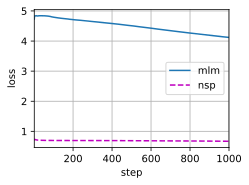

In [30]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=1e-3)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached: # 数据集比较大，所以计算多个batch而非数据集中的全部数据
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net, loss, vocab_size, tokens_X, segments_X, valid_lens_x,
                pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1,
                         (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

train_bert(train_iter, net, loss, len(vocab), devices, num_steps=1000)

Representing Text with BERT

In [26]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑句子"a crane is flying"

In [27]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
# batch，seqlen(+cls seq)
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3],encoded_text_crane.shape

(torch.Size([1, 6, 128]),
 torch.Size([1, 128]),
 tensor([ 0.2771,  0.8338, -0.2570], device='cuda:0', grad_fn=<SliceBackward0>),
 torch.Size([1, 128]))

考虑一个句子对"a crane driver came" and "he just left"<br>
可以看到每个词抽取了一个长为128的特征

In [28]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

(torch.Size([1, 10, 128]),
 torch.Size([1, 128]),
 tensor([ 0.0166,  0.5957, -0.1832], device='cuda:0', grad_fn=<SliceBackward0>))